# Problem 2
## Part a
First, redo all the dataset setup that was done in Problem 1

In [2]:
!pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.4-cp37-none-any.whl size=8573 sha256=7dd522503d115970fc9cf4ae529f31a130810b9f61c3956de3b9cd517390030d
  Stored in directory: /root/.cache/pip/wheels/4a/98/93/570ea2949d33c4c0960a8e85bc8725fe37706b933d4e5b173b
Successfully built ptflops


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
               
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {6: 0, 7: 1, 8: 2, 9: 3}
class_names = ['frog', 'horse', 'ship', 'truck']
cifar4 = [(img, label_map[label])
          for img, label in cifar10 
          if label in label_map.keys()]
cifar4_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in label_map.keys()]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/


Define the convolutional model

In [4]:
import torch.nn.functional as F

class Net_a(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 4)  # Changed to 4 to accomodate new classes
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Define training loop

In [5]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    losses = []
    
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        losses.append((epoch, loss_train / len(train_loader)))

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

    return losses

Define validation loop

In [6]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

Train the convolution model

In [18]:
import time

train_loader = torch.utils.data.DataLoader(cifar4, batch_size=64,
                                           shuffle=True)

model = Net_a()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

t = time.time()
losses_a = training_loop(
    n_epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print('Elapsed time: {}'.format(time.time() - t))

2021-04-22 21:20:35.146239 Epoch 1, Training loss 1.141325918439859
2021-04-22 21:21:31.046458 Epoch 10, Training loss 0.4913569407912489
2021-04-22 21:22:33.281006 Epoch 20, Training loss 0.33632465254384486
2021-04-22 21:23:35.644546 Epoch 30, Training loss 0.28119699064249426
2021-04-22 21:24:38.018949 Epoch 40, Training loss 0.24309933540253595
2021-04-22 21:25:40.414188 Epoch 50, Training loss 0.21335985736487012
2021-04-22 21:26:42.692638 Epoch 60, Training loss 0.1920021339513052
2021-04-22 21:27:44.949844 Epoch 70, Training loss 0.16884093262707464
2021-04-22 21:28:47.632500 Epoch 80, Training loss 0.14990181233674382
2021-04-22 21:29:50.498848 Epoch 90, Training loss 0.13301754245361963
2021-04-22 21:30:53.155165 Epoch 100, Training loss 0.11911918619832101
2021-04-22 21:31:55.747150 Epoch 110, Training loss 0.10477812482288089
2021-04-22 21:32:58.289577 Epoch 120, Training loss 0.09302785718283904
2021-04-22 21:34:01.108562 Epoch 130, Training loss 0.08051739616420703
2021-04

Validate the trained model

In [8]:
val_loader = torch.utils.data.DataLoader(cifar4_val, batch_size=64,
                                         shuffle=False)

validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.90


Check complexity

In [13]:
from ptflops import get_model_complexity_info
with torch.cuda.device(0):
    macs, params=get_model_complexity_info(model,(3,32,32)) # Is this right? Batch size is not considered...
    print(macs, params)

Net_a(
  0.018 M, 100.000% Params, 0.001 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.0 M, 2.468% Params, 0.0 GMac, 59.404% MACs, 3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(0.001 M, 6.389% Params, 0.0 GMac, 38.453% MACs, 16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(0.016 M, 90.416% Params, 0.0 GMac, 2.126% MACs, in_features=512, out_features=32, bias=True)
  (fc2): Linear(0.0 M, 0.727% Params, 0.0 GMac, 0.017% MACs, in_features=32, out_features=4, bias=True)
)
0.0 GMac 18.16 k


## Part b
Define a new model for 10 output classes

In [14]:
import torch.nn.functional as F

class Net_b(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)  # Changed to 10 to accomodate new classes
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Train and validate

In [15]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)

model = Net_b()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

t = time.time()
losses_b = training_loop(
    n_epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print('Elapsed time: {}'.format(time.time() - t))

validate(model, train_loader, val_loader)

2021-04-22 20:05:03.373823 Epoch 1, Training loss 2.0968999493762355
2021-04-22 20:08:22.757585 Epoch 10, Training loss 1.220485776891489
2021-04-22 20:12:04.387504 Epoch 20, Training loss 1.0317340926136203
2021-04-22 20:15:47.519602 Epoch 30, Training loss 0.936105378372285
2021-04-22 20:19:31.940047 Epoch 40, Training loss 0.8789221308267939
2021-04-22 20:23:15.738031 Epoch 50, Training loss 0.8386711752628122
2021-04-22 20:26:59.844694 Epoch 60, Training loss 0.8069845778329293
2021-04-22 20:30:44.536457 Epoch 70, Training loss 0.7792004580464205
2021-04-22 20:34:28.623401 Epoch 80, Training loss 0.7573825865602859
2021-04-22 20:38:12.248560 Epoch 90, Training loss 0.736974322315677
2021-04-22 20:41:56.293249 Epoch 100, Training loss 0.7188578715257328
2021-04-22 20:45:40.210654 Epoch 110, Training loss 0.7025108345405525
2021-04-22 20:49:23.752788 Epoch 120, Training loss 0.6881337762260071
2021-04-22 20:53:07.602079 Epoch 130, Training loss 0.6738305078138171
2021-04-22 20:56:51.

RuntimeError: ignored

Check complexity

In [17]:
with torch.cuda.device(0):
    macs, params=get_model_complexity_info(model,(3,32,32))
    print(macs, params)

Net_b(
  0.018 M, 100.000% Params, 0.001 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.0 M, 2.441% Params, 0.0 GMac, 59.389% MACs, 3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(0.001 M, 6.320% Params, 0.0 GMac, 38.444% MACs, 16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(0.016 M, 89.441% Params, 0.0 GMac, 2.125% MACs, in_features=512, out_features=32, bias=True)
  (fc2): Linear(0.0 M, 1.798% Params, 0.0 GMac, 0.043% MACs, in_features=32, out_features=10, bias=True)
)
0.0 GMac 18.35 k


## Part c 
Define new model with another layer of convolutions

In [23]:
import torch.nn.functional as F

class Net_c(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)  # New layer of convolutions
        self.fc1 = nn.Linear(4 * 4 * 4, 32)  # 8 becomes 4 because of additional 2x2 max pool
        self.fc2 = nn.Linear(32, 10)  # Changed to 10 to accomodate new classes
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)  # New max pool
        out = out.view(-1, 4 * 4 * 4)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Train and validate

In [24]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)

model = Net_c()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

t = time.time()
losses_c = training_loop(
    n_epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print('Elapsed time: {}'.format(time.time() - t))

validate(model, train_loader, val_loader)

2021-04-22 21:57:47.490896 Epoch 1, Training loss 2.213280374436732
2021-04-22 22:01:15.183428 Epoch 10, Training loss 1.395973279652998
2021-04-22 22:05:05.478940 Epoch 20, Training loss 1.2187246330406354
2021-04-22 22:08:54.286112 Epoch 30, Training loss 1.1262739583506913
2021-04-22 22:12:43.562642 Epoch 40, Training loss 1.0711276384875597
2021-04-22 22:16:33.262828 Epoch 50, Training loss 1.0380844267280511
2021-04-22 22:20:22.780990 Epoch 60, Training loss 1.0122623747724402
2021-04-22 22:24:11.571801 Epoch 70, Training loss 0.9962229510707319
2021-04-22 22:28:00.171785 Epoch 80, Training loss 0.9822924445047403
2021-04-22 22:31:48.265865 Epoch 90, Training loss 0.9690905699644552
2021-04-22 22:35:37.382622 Epoch 100, Training loss 0.9575529003234775
2021-04-22 22:39:25.626603 Epoch 110, Training loss 0.9505352225449993
2021-04-22 22:43:14.078988 Epoch 120, Training loss 0.9409439735247961
2021-04-22 22:47:02.455195 Epoch 130, Training loss 0.9350889220719447
2021-04-22 22:50:50

Check complexity

In [25]:
with torch.cuda.device(0):
    macs, params=get_model_complexity_info(model,(3,32,32))
    print(macs, params)

Net_c(
  0.004 M, 100.000% Params, 0.001 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.0 M, 10.394% Params, 0.0 GMac, 59.056% MACs, 3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(0.001 M, 26.914% Params, 0.0 GMac, 38.228% MACs, 16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(0.0 M, 6.775% Params, 0.0 GMac, 2.406% MACs, 8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(0.002 M, 48.260% Params, 0.0 GMac, 0.268% MACs, in_features=64, out_features=32, bias=True)
  (fc2): Linear(0.0 M, 7.657% Params, 0.0 GMac, 0.042% MACs, in_features=32, out_features=10, bias=True)
)
0.0 GMac 4.31 k


Plot all three losses

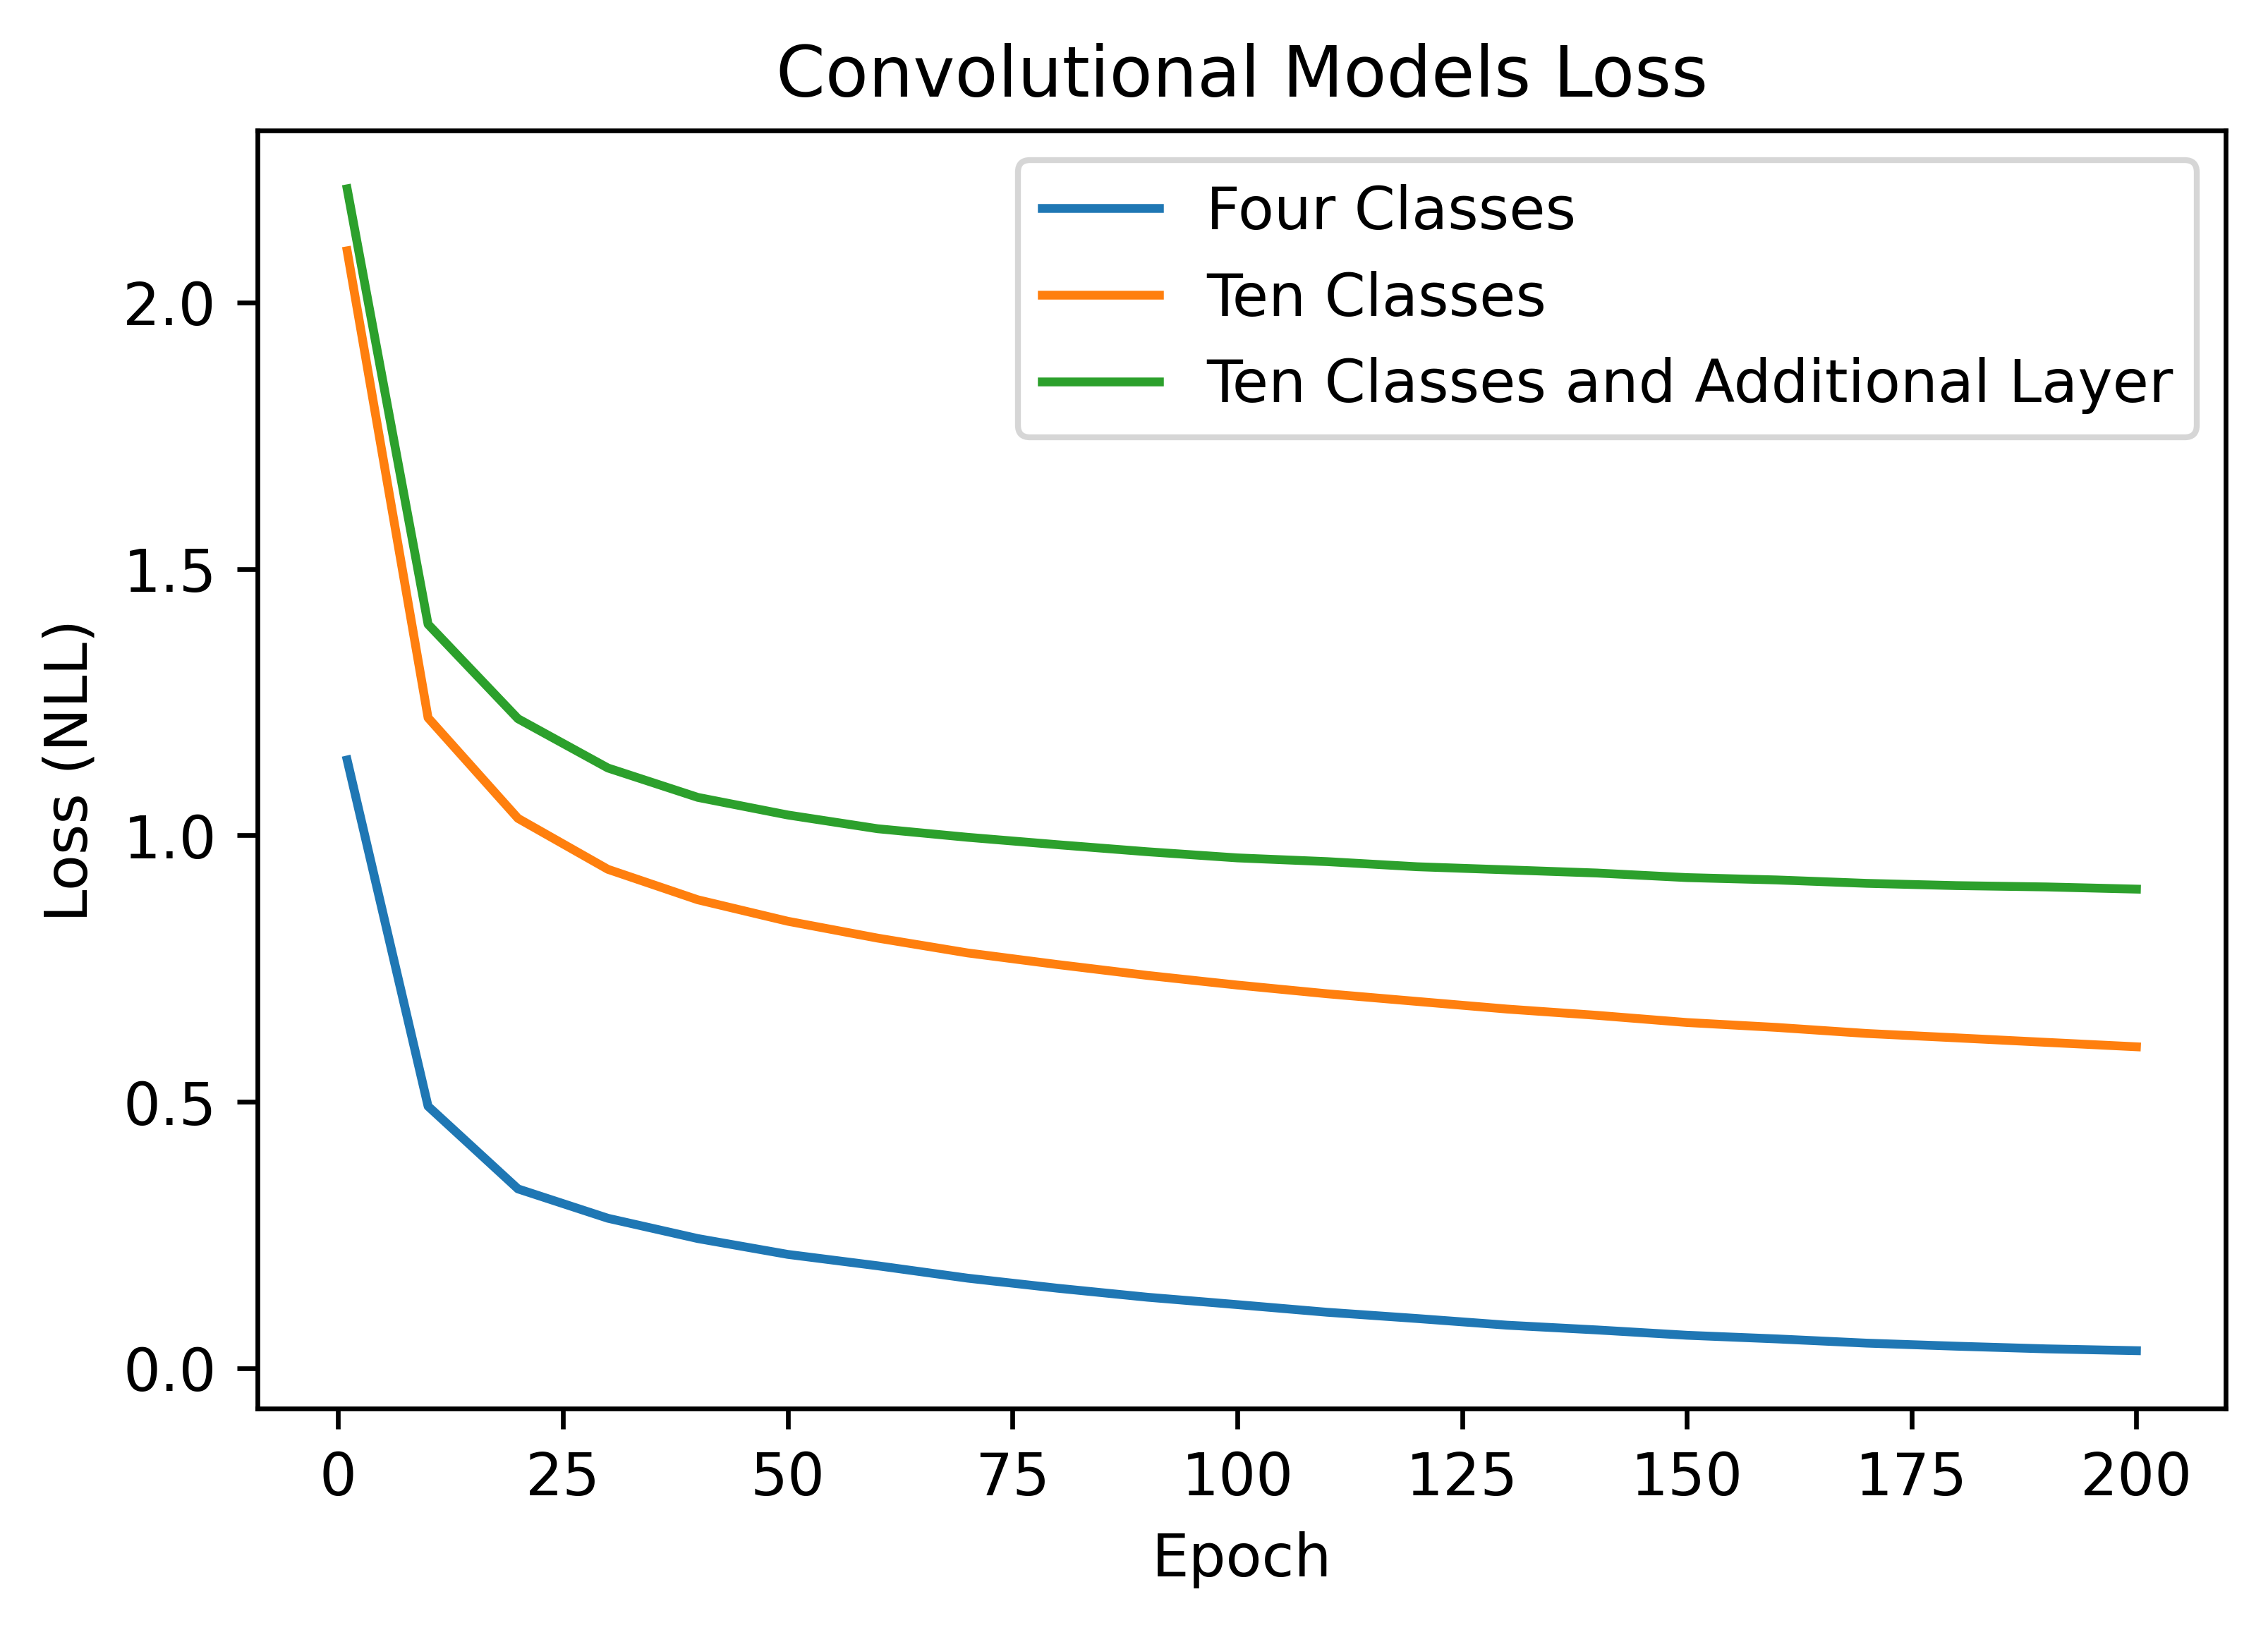

In [33]:
# Set up figure for loss visualization
fig = plt.figure(dpi=600)
plt.xlabel("Epoch")
plt.ylabel("Loss (NLL)")
parta, = plt.plot(*zip(*losses_a))  # Plot loss from part a
partb, = plt.plot(*zip(*losses_b)) # Plot loss from part b
partc, = plt.plot(*zip(*losses_c)) # Plot loss from part c
plt.legend([parta, partb, partc], ['Four Classes', 'Ten Classes', 'Ten Classes and Additional Layer'])
plt.title("Convolutional Models Loss")
plt.savefig("Conv loss.png", format="png")